In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

I chose the Mean Absolute Error (MAE) metric because:
- **Simple and Intuitive:** MAE calculates the average absolute difference between the actual values and the predictions, and is expressed in the same unit as the target (e.g., sales).
- **Easy Interpretation:** This makes it easy to interpret and directly compare the forecast error to the actual values.
- **Robust to Outliers:** Additionally, MAE does not overly penalize large errors, offering a more robust evaluation in scenarios where extreme outliers might otherwise skew the assessment.

## Data Loading

In [55]:
train_df = pd.read_parquet('../data/train.snap.parquet')
test_df = pd.read_parquet('../data/test.snap.parquet')

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159132 entries, 0 to 12159131
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   y             float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  event_name_1  category      
 11  event_type_1  category      
 12  event_name_2  category      
 13  event_type_2  category      
 14  snap_CA       uint8         
 15  snap_TX       uint8         
 16  snap_WI       uint8         
 17  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(2), uint16(1), uint8(3)
memory usage: 360.9 MB


In [48]:
train_df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,d,y,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1542,1.0,2015-04-19,11512,nan,nan,nan,nan,0,0,0,2.240234
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1543,0.0,2015-04-20,11512,nan,nan,nan,nan,0,0,0,2.240234
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1544,0.0,2015-04-21,11512,nan,nan,nan,nan,0,0,0,2.240234
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1545,0.0,2015-04-22,11512,nan,nan,nan,nan,0,0,0,2.240234
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1546,1.0,2015-04-23,11512,nan,nan,nan,nan,0,0,0,2.240234


## Compute Forecasts from Training Data

### Create Forecast Based on Daily (Weekday) Averages

- A new column, `weekday`, is added to the training dataset by extracting the day of the week from the `date` column.  
- The DataFrame is grouped by `item_id`, `store_id`, and `weekday` to compute the average sales (`y`) for each group.  
- The resulting column is renamed to `y_weekday_average`, representing the baseline forecast for each day of the week.

In [50]:
# Add weekday column to training data
train_df['weekday'] = train_df['date'].dt.weekday

# Group by item_id, store_id, and weekday and compute the average sales
daily_avg = train_df.groupby(['item_id', 'store_id', 'weekday'])['y'].mean().reset_index()
daily_avg.rename(columns={'y': 'daily_forecast'}, inplace=True)
daily_avg

/var/folders/4d/7pshjxj13f91ntw0zt1jz2br0000gn/T/ipykernel_54050/3754910446.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_avg = train_df.groupby(['item_id', 'store_id', 'weekday'])['y'].mean().reset_index()


,item_id,store_id,weekday,daily_forecast
0,HOBBIES_1_001,CA_1,0,0.684211
1,HOBBIES_1_001,CA_1,1,0.789474
2,HOBBIES_1_001,CA_1,2,0.684211
3,HOBBIES_1_001,CA_1,3,0.578947
4,HOBBIES_1_001,CA_1,4,0.614035
...,...,...,...,...
213425,FOODS_3_827,WI_3,2,1.754386
213426,FOODS_3_827,WI_3,3,1.263158
213427,FOODS_3_827,WI_3,4,1.596491
213428,FOODS_3_827,WI_3,5,1.666667


In [49]:
daily_avg

,item_id,store_id,weekday,daily_forecast
0,HOBBIES_1_001,CA_1,0,0.684211
1,HOBBIES_1_001,CA_1,1,0.789474
2,HOBBIES_1_001,CA_1,2,0.684211
3,HOBBIES_1_001,CA_1,3,0.578947
4,HOBBIES_1_001,CA_1,4,0.614035
...,...,...,...,...
213425,FOODS_3_827,WI_3,2,1.754386
213426,FOODS_3_827,WI_3,3,1.263158
213427,FOODS_3_827,WI_3,4,1.596491
213428,FOODS_3_827,WI_3,5,1.666667


### Create Forecast Based on Weekly (Weekday) Averages

In [52]:
# Extract week number using the ISO calendar
train_df['week'] = train_df['date'].dt.isocalendar().week
# Group by item_id, store_id, and week to compute the average sales
weekly_avg = train_df.groupby(['item_id', 'store_id', 'week'])['y'].mean().reset_index()
weekly_avg.rename(columns={'y': 'weekly_forecast'}, inplace=True)
weekly_avg

/var/folders/4d/7pshjxj13f91ntw0zt1jz2br0000gn/T/ipykernel_54050/1210361198.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_avg = train_df.groupby(['item_id', 'store_id', 'week'])['y'].mean().reset_index()


,item_id,store_id,week,weekly_forecast
0,HOBBIES_1_001,CA_1,1,1.142857
1,HOBBIES_1_001,CA_1,2,0.714286
2,HOBBIES_1_001,CA_1,3,0.857143
3,HOBBIES_1_001,CA_1,4,0.571429
4,HOBBIES_1_001,CA_1,5,0.571429
...,...,...,...,...
1615965,FOODS_3_827,WI_3,49,1.000000
1615966,FOODS_3_827,WI_3,50,1.571429
1615967,FOODS_3_827,WI_3,51,1.714286
1615968,FOODS_3_827,WI_3,52,1.714286


## Prepare Test Data by Adding Necessary Columns


In [57]:
test_df['weekday'] = test_df['date'].dt.weekday
test_df['week'] = test_df['date'].dt.isocalendar().week
test_df

/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,d,y,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekday,week
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2,2016-05-23,11617,nan,nan,nan,nan,0,0,0,8.382812,0,21
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,2016-05-23,11617,nan,nan,nan,nan,0,0,0,3.970703,0,21
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,2016-05-23,11617,nan,nan,nan,nan,0,0,0,2.970703,0,21
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,2016-05-23,11617,nan,nan,nan,nan,0,0,0,4.640625,0,21
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2,2016-05-23,11617,nan,nan,nan,nan,0,0,0,2.880859,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,6,24
853716,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,6,24
853717,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469,6,24
853718,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,5,2016-06-19,11621,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273,6,24


## Merge Forecasts with Test Data

In [76]:
# Merge daily forecast with test data
test_daily = test_df.merge(daily_avg, on=['item_id', 'store_id', 'weekday'], how='left')

# Merge weekly forecast with test data
test_weekly = test_df.merge(weekly_avg, on=['item_id', 'store_id', 'week'], how='left')

In [81]:
# Replaces NaNs with the weekly general average to avoid errors in the MAE
overall_weekly_avg = weekly_avg['weekly_forecast'].mean()
test_weekly['weekly_forecast'].fillna(overall_weekly_avg, inplace=True)

/var/folders/4d/7pshjxj13f91ntw0zt1jz2br0000gn/T/ipykernel_54050/3135352158.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_weekly['weekly_forecast'].fillna(overall_weekly_avg, inplace=True)


The NaN treatment was necessary for the weekly average due to the lower data density compared to the days. In the case of the daily average, the distribution of data over time was more uniform, avoiding the problem. The ideal is to choose a filling that makes sense in the context of the business and the expected sales pattern.

## Evaluate the Forecasts using MAE

In [94]:
mae_daily = mean_absolute_error(test_daily['y'], test_daily['daily_forecast'])
mae_weekly = mean_absolute_error(test_weekly['y'], test_weekly['weekly_forecast'])
print(f'Daily Forecast MAE: {mae_daily:.4f}')
print(f'Weekly Forecast MAE: {mae_weekly:.4f}')

Daily Forecast MAE: 1.1315
Weekly Forecast MAE: 1.2791


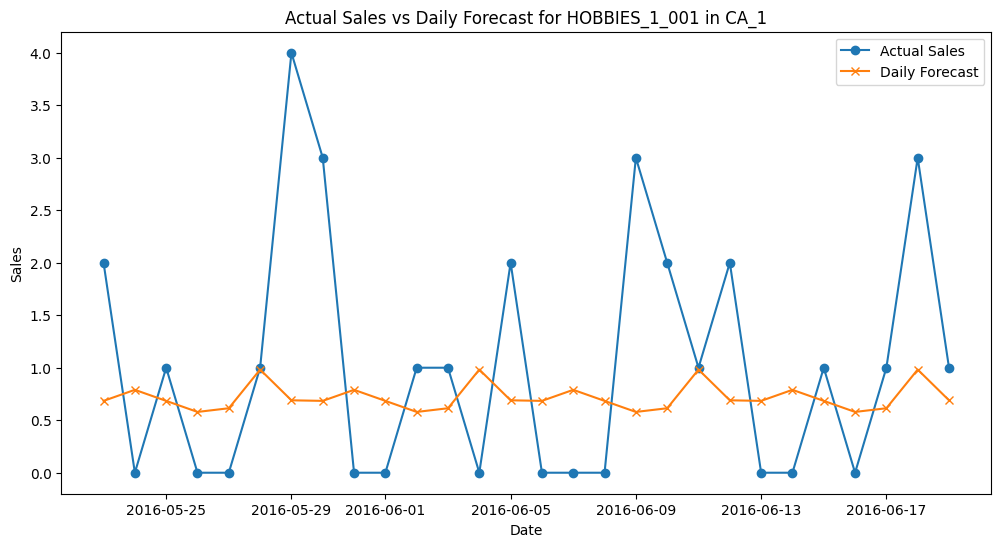

In [70]:
# Select a sample product and store from the test data
sample_item = test_daily['item_id'].iloc[0]
sample_store = test_daily['store_id'].iloc[0]

# Filter sample data for the selected product-store pair (Daily Forecast)
sample_daily = test_daily[(test_daily['item_id'] == sample_item) & (test_daily['store_id'] == sample_store)]
sample_daily = sample_daily.sort_values('date')

plt.figure(figsize=(12,6))
plt.plot(sample_daily['date'], sample_daily['y'], label='Actual Sales', marker='o')
plt.plot(sample_daily['date'], sample_daily['daily_forecast'], label='Daily Forecast', marker='x')
plt.title(f'Actual Sales vs Daily Forecast for {sample_item} in {sample_store}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

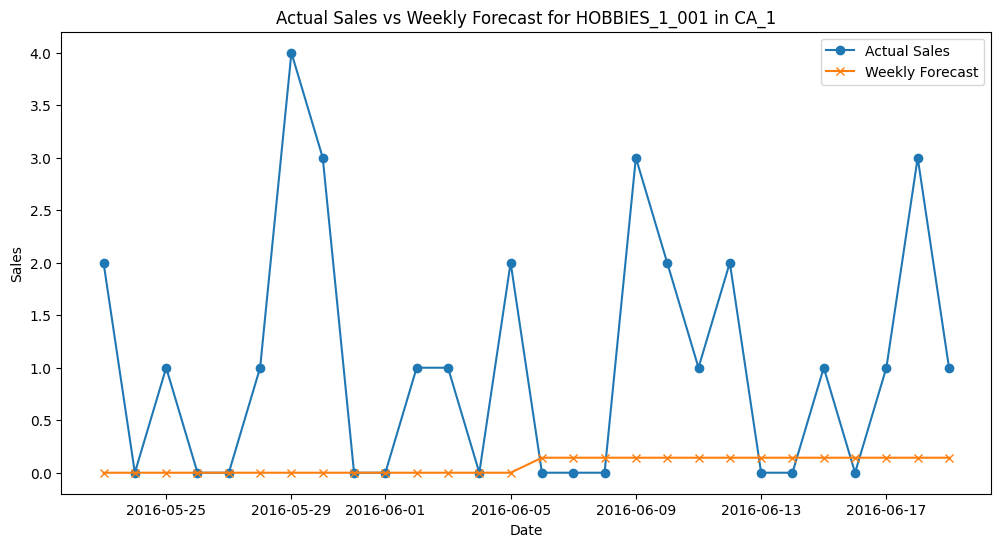

In [84]:
# Filter sample data for the selected product-store pair (Weekly Forecast)
sample_weekly = test_weekly[(test_weekly['item_id'] == sample_item) & (test_weekly['store_id'] == sample_store)]
sample_weekly = sample_weekly.sort_values('date')

plt.figure(figsize=(12,6))
plt.plot(sample_weekly['date'], sample_weekly['y'], label='Actual Sales', marker='o')
plt.plot(sample_weekly['date'], sample_weekly['weekly_forecast'], label='Weekly Forecast', marker='x')
plt.title(f'Actual Sales vs Weekly Forecast for {sample_item} in {sample_store}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 

In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853720 entries, 0 to 853719
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            853720 non-null  category      
 1   item_id       853720 non-null  category      
 2   dept_id       853720 non-null  category      
 3   cat_id        853720 non-null  category      
 4   store_id      853720 non-null  category      
 5   state_id      853720 non-null  category      
 6   d             853720 non-null  category      
 7   y             853720 non-null  int16         
 8   date          853720 non-null  datetime64[ns]
 9   wm_yr_wk      853720 non-null  uint16        
 10  event_name_1  853720 non-null  category      
 11  event_type_1  853720 non-null  category      
 12  event_name_2  853720 non-null  category      
 13  event_type_2  853720 non-null  category      
 14  snap_CA       853720 non-null  uint8         
 15  snap_TX       853

In [106]:
# List of forecast days
days = [f'd_{c}' for c in range(1942, 1970)]

# Iterate through each day to calculate the MAE for both daily and weekly forecasts
for d in days:
    # Filter the test dataset for the specific day
    teste_filter = test_df.copy()
    teste_filter = teste_filter[teste_filter['d'] == d]

    # Calculate MAE for the daily forecast
    mae_daily = mean_absolute_error(teste_filter['y'], teste_filter['weekday'])

    # Calculate MAE for the weekly forecast (no NaN handling)
    mae_weekly = mean_absolute_error(teste_filter['y'], teste_filter['week'])

    # Print the results for comparison
    print(f"Day: {d} | Daily Forecast MAE: {mae_daily:.4f} | Weekly Forecast MAE: {mae_weekly:.4f}")

Day: d_1942 | Daily Forecast MAE: 1.3245 | Weekly Forecast MAE: 19.7710
Day: d_1943 | Daily Forecast MAE: 1.3814 | Weekly Forecast MAE: 19.8609
Day: d_1944 | Daily Forecast MAE: 1.9167 | Weekly Forecast MAE: 19.9005
Day: d_1945 | Daily Forecast MAE: 2.6695 | Weekly Forecast MAE: 19.8846
Day: d_1946 | Daily Forecast MAE: 3.5157 | Weekly Forecast MAE: 19.8158
Day: d_1947 | Daily Forecast MAE: 4.3766 | Weekly Forecast MAE: 19.6352
Day: d_1948 | Daily Forecast MAE: 5.2581 | Weekly Forecast MAE: 19.7149
Day: d_1949 | Daily Forecast MAE: 1.3888 | Weekly Forecast MAE: 20.7731
Day: d_1950 | Daily Forecast MAE: 1.3602 | Weekly Forecast MAE: 20.8547
Day: d_1951 | Daily Forecast MAE: 1.9834 | Weekly Forecast MAE: 20.7237
Day: d_1952 | Daily Forecast MAE: 2.7043 | Weekly Forecast MAE: 20.8334
Day: d_1953 | Daily Forecast MAE: 3.5559 | Weekly Forecast MAE: 20.6468
Day: d_1954 | Daily Forecast MAE: 4.3482 | Weekly Forecast MAE: 20.5216
Day: d_1955 | Daily Forecast MAE: 5.1995 | Weekly Forecast MAE: 

In [97]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853720 entries, 0 to 853719
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            853720 non-null  category      
 1   item_id       853720 non-null  category      
 2   dept_id       853720 non-null  category      
 3   cat_id        853720 non-null  category      
 4   store_id      853720 non-null  category      
 5   state_id      853720 non-null  category      
 6   d             853720 non-null  category      
 7   y             853720 non-null  int16         
 8   date          853720 non-null  datetime64[ns]
 9   wm_yr_wk      853720 non-null  uint16        
 10  event_name_1  853720 non-null  category      
 11  event_type_1  853720 non-null  category      
 12  event_name_2  853720 non-null  category      
 13  event_type_2  853720 non-null  category      
 14  snap_CA       853720 non-null  uint8         
 15  snap_TX       853